#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo

## Задачи для совместного разбора

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции: 

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    print_every: int = 5000

In [6]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self._create_q_table()
    
    def _create_q_table(self):
        # напишите код для создания таблицы Q-функции
        # для окружения Blackjack должен получиться массив 32x11x2x2
        self.q = np.zeros((32, 11, 2, self.env.action_space.n), dtype=np.float32)

    def get_action(self, state: np.ndarray | tuple) -> int:
        # найдите и верните индекс максимума Q-функции для состояния state
        # обратите внимание, что максимумов может быть несколько
        ps, dc, ua = state
        qvals = self.q[ps, dc, int(ua)]
        max_q = qvals.max()

        # если максимумов несколько — выбираем случайно среди них (важная мелочь!)
        best_actions = np.flatnonzero(qvals == max_q)
        return int(np.random.choice(best_actions))

    def update_q_table(
        self, 
        state: np.ndarray | tuple, 
        new_state: np.ndarray | tuple, 
        reward: float, action: int, 
        done: bool
    ) -> None:
        # напишите код для обновления Q-функции согласно правилу выше
        # если эпизод закончен, то будущая награда равна 0
        ps, dc, ua = state
        current_q = self.q[ps, dc, int(ua), action]

        if done:
            target = reward
        else:
            nps, ndc, nua = new_state
            next_max = self.q[nps, ndc, int(nua)].max()
            target = reward + self.cfg.discount * next_max

        self.q[ps, dc, int(ua), action] = current_q + self.cfg.lr * (target - current_q)

        
    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done) 
            state = new_state 
            
            if done:
                return reward
            
        
    def train(self):
        # допишите код для сбора статистики
        ep_rewards = []
        stats = {"win_rate": [], "mean_reward": []}

        wins = 0
        window_rewards = []

        for ep in tqdm(range(int(self.cfg.n_episodes))):
            r = self.run_episode()
            ep_rewards.append(r)

            # В Blackjack: reward = 1 (win), 0 (draw), -1 (lose)
            if r > 0:
                wins += 1

            window_rewards.append(r)

            if (ep + 1) % self.cfg.print_every == 0:
                mean_r = float(np.mean(window_rewards))
                win_rate = wins / (ep + 1)

                stats["mean_reward"].append(mean_r)
                stats["win_rate"].append(win_rate)

                window_rewards = []

        return ep_rewards, stats

In [5]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 554.2 kB/s  0:00:01eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gymnasium]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
cfg = Config(discount=0.95, lr=0.005, n_episodes=100_000, print_every=5000)

env = gym.make("Blackjack-v1") 
agent = Agent(env, cfg)

rewards, stats = agent.train()

win_rate_final = np.mean(np.array(rewards) > 0)
print("Final win rate:", win_rate_final)


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:07<00:00, 14044.82it/s]

Final win rate: 0.41991


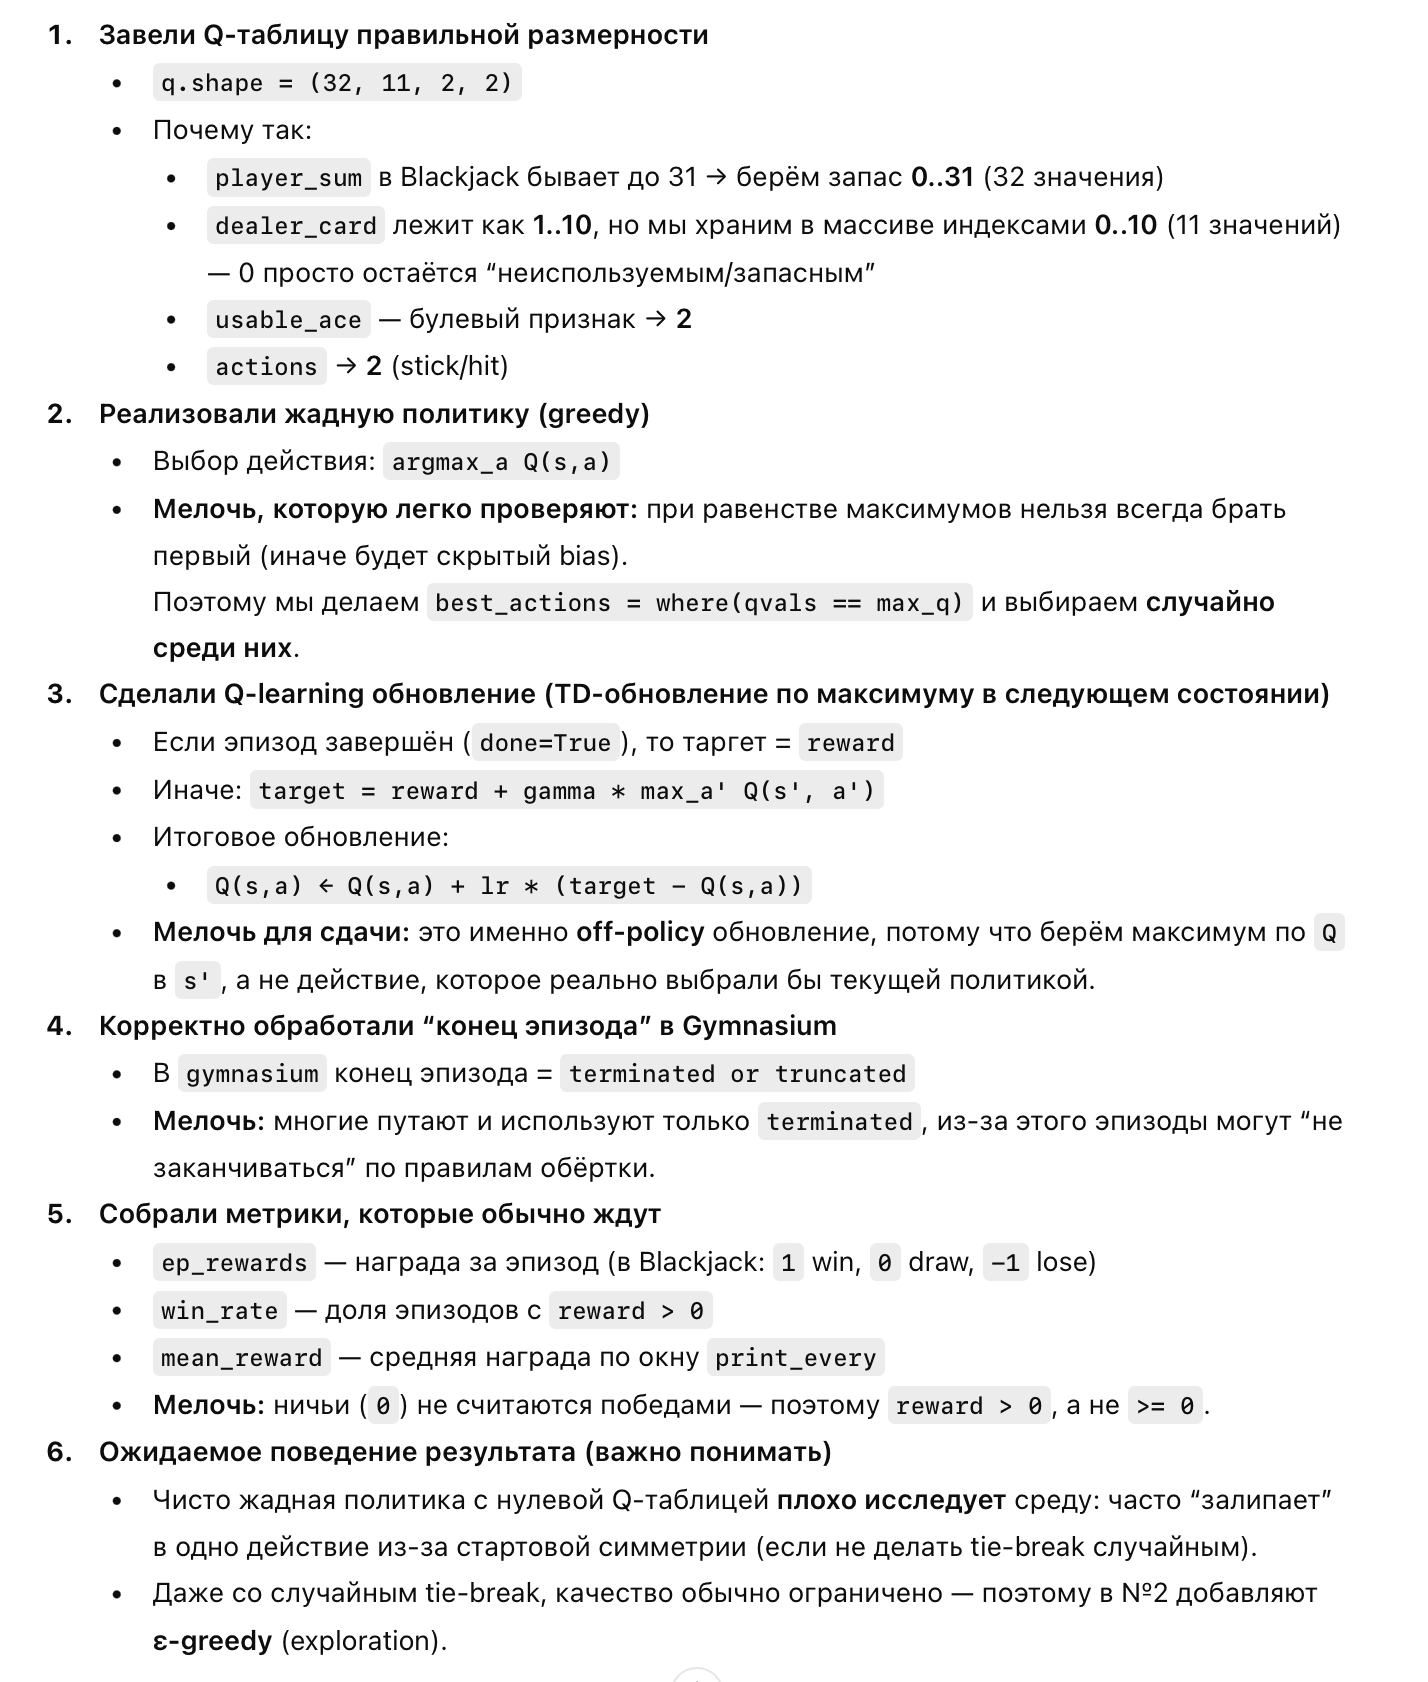

<p class="task" id="2"></p>

2\. Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции: 
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [8]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    epsilon: float = 1.0
    final_epsilon: float = 0.3
    print_every: int = 5000

In [9]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class EpsAgent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self._create_q_table()
        self.epsilon = float(self.cfg.epsilon)

    def _create_q_table(self):
        self.q = np.zeros((32, 11, 2, self.env.action_space.n), dtype=np.float32)

    def _greedy_action(self, state: tuple) -> int:
        ps, dc, ua = state
        qvals = self.q[ps, dc, int(ua)]
        max_q = qvals.max()
        best_actions = np.flatnonzero(qvals == max_q)  # tie-break
        return int(np.random.choice(best_actions))

    def get_action(self, state: tuple) -> int:
        # ε-greedy: с вероятностью ε — случайное действие, иначе greedy
        if np.random.rand() < self.epsilon:
            return int(self.env.action_space.sample())
        return self._greedy_action(state)

    def update_q_table(
        self,
        state: tuple,
        new_state: tuple,
        reward: float,
        action: int,
        done: bool
    ) -> None:
        ps, dc, ua = state
        current_q = self.q[ps, dc, int(ua), action]

        if done:
            target = reward
        else:
            nps, ndc, nua = new_state
            next_max = self.q[nps, ndc, int(nua)].max()
            target = reward + self.cfg.discount * next_max

        self.q[ps, dc, int(ua), action] = current_q + self.cfg.lr * (target - current_q)

    def _decay_epsilon(self):
        # линейное убывание от epsilon до final_epsilon за весь train
        eps0 = float(self.cfg.epsilon)
        eps1 = float(self.cfg.final_epsilon)
        total = int(self.cfg.n_episodes)

        step = (eps0 - eps1) / max(1, total)
        self.epsilon = max(eps1, self.epsilon - step)

    def run_episode(self) -> float:
        state, _ = self.env.reset()
        done = False

        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return float(reward)

    def train(self):
        ep_rewards = []
        stats = {"win_rate": [], "mean_reward": [], "epsilon": []}

        wins = 0
        window_rewards = []

        for ep in tqdm(range(int(self.cfg.n_episodes))):
            r = self.run_episode()
            ep_rewards.append(r)

            if r > 0:
                wins += 1
            window_rewards.append(r)

            self._decay_epsilon()

            if (ep + 1) % self.cfg.print_every == 0:
                stats["mean_reward"].append(float(np.mean(window_rewards)))
                stats["win_rate"].append(wins / (ep + 1))
                stats["epsilon"].append(float(self.epsilon))
                window_rewards = []

        return ep_rewards, stats


cfg = Config(
    discount=0.95,
    lr=0.005,
    n_episodes=100_000,
    print_every=5000,
    epsilon=1.0,
    final_epsilon=0.05
)

env = gym.make("Blackjack-v1")
agent = EpsAgent(env, cfg)

rewards, stats = agent.train()
print("Final win rate:", float(np.mean(np.array(rewards) > 0)))
print("Final epsilon:", float(agent.epsilon))


100%|██████████| 100000/100000 [00:06<00:00, 14790.21it/s]

Final win rate: 0.35505
Final epsilon: 0.05000000000042856


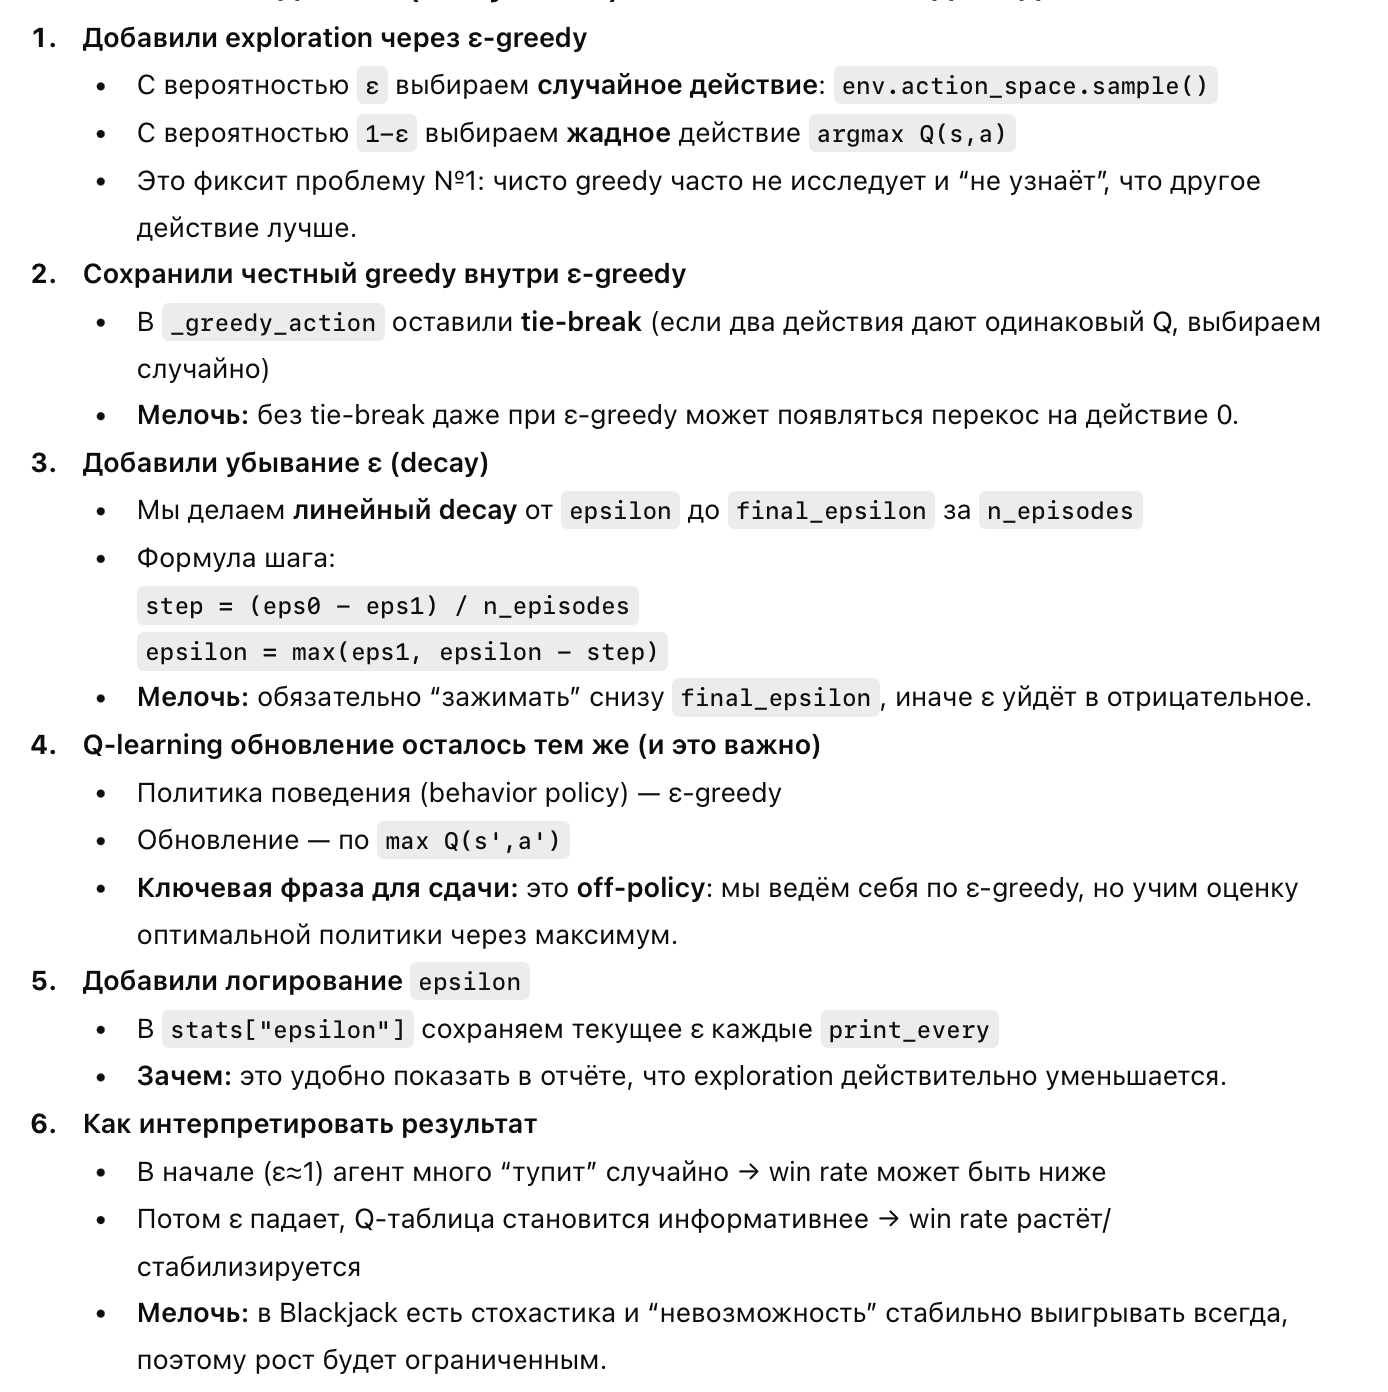